In [1]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics
import scipy.sparse as sp
from celldreamer.eval.eval_utils import join_real_generated

from torch import nn
import scanpy as sc    

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
import random
from celldreamer.models.base.encoder_model import EncoderModel
from celldreamer.models.base.utils import unsqueeze_right
from celldreamer.paths import DATA_DIR

device  = "cuda" if torch.cuda.is_available() else "cpu"

sc.set_figure_params(dpi=100, frameon=False, fontsize=12)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Step 1: Initialize data

In [2]:
dataset_config = {'dataset_path': DATA_DIR / 'processed_full_genome' / 'neurips' / 'neurips_test.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['cell_type', 'Site'],
                    'subsample_frac': 1,
                    'encoder_type': 'learnt_autoencoder',
                    'one_hot_encode_features': False,
                    'split_rates': [0.90, 0.10],
                    'cov_embedding_dimensions': 128, 
                    'multimodal': False, 
                    'is_binarized': False,
                    'theta_covariate': 'cell_type', 
                    'size_factor_covariate': 'DonorNumber',
                    'guidance_weights': {'cell_type': 1, 'DonorNumber': 1}
                 }

data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                        layer_key=dataset_config["layer_key"],
                        covariate_keys=dataset_config["covariate_keys"],
                        subsample_frac=dataset_config["subsample_frac"], 
                        encoder_type=dataset_config["encoder_type"],
                        multimodal=dataset_config["multimodal"],
                        is_binarized=dataset_config["is_binarized"]
                      )

dataloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=256,
                                            shuffle=True,
                                            num_workers=4, 
                                            drop_last=True)

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}

n_cat = len(dataset.id2cov["cell_type"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Step 2: Initialize encoder

In [3]:
encoder_config = {
    "x0_from_x_kwargs": {
        "dims": [512, 256, 50],
        "batch_norm": True,
        "dropout": False,
        "dropout_p": 0.0
    },
    "learning_rate": 0.001,
    "weight_decay": 0.00001,
    "covariate_specific_theta": False, 
    "multimodal": False,
    "is_binarized": False}


state_dict_path = "/home/icb/alessandro.palma/environment/cfgen/project_folder/experiments/off_train_autoencoder_neurips_whole_genome/eabc6534-947b-4486-8012-c9e351b297ca/checkpoints/epoch_59.ckpt"

In [4]:
encoder_model = EncoderModel(in_dim=in_dim,
                              n_cat=n_cat,
                              conditioning_covariate=dataset_config["theta_covariate"], 
                              encoder_type=dataset_config["encoder_type"],
                              **encoder_config)

encoder_model.eval()

encoder_model.load_state_dict(torch.load(state_dict_path)["state_dict"])

<All keys matched successfully>

## Initialize FM model

In [5]:
generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'sigma': 0.5}

In [6]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/cfgen/project_folder/experiments/MULTILAB_NEURIPS_SITE/89ef421b-dee5-4a69-81a6-918ab226d7ac/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model.multimodal = False

In [7]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["cell_type"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[-0.4309, -0.4496,  1.1591,  ...,  0.8151, -0.3812,  0.9965],
        [-0.9857,  0.5936,  1.2165,  ...,  0.2363, -0.7194,  1.2550],
        [ 0.1254, -1.0706,  0.8357,  ...,  0.0295,  0.4774,  0.1402],
        ...,
        [ 0.3165, -0.8528, -0.6932,  ...,  0.7603, -0.4992,  0.7339],
        [ 0.7572,  1.2625, -0.2281,  ...,  0.7314, -1.8783,  3.3249],
        [ 2.2979,  1.7647, -0.1750,  ..., -0.2253, -1.6298,  1.3355]],
       device='cuda:0', requires_grad=True)


Initializations

In [8]:
generative_model = FM(
            encoder_model=encoder_model,
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=50,
            size_factor_statistics=size_factor_statistics,
            covariate_list=dataset_config["covariate_keys"],
            theta_covariate=dataset_config["theta_covariate"],
            size_factor_covariate=dataset_config["size_factor_covariate"],
            model_type=denoising_model.model_type, 
            encoder_type=dataset_config["encoder_type"],
            multimodal=dataset_config["multimodal"],
            is_binarized=False,
            modality_list=None,
            guidance_weights={'cell_type': 1, 'Site': 1},
            **generative_model_config  # model_kwargs should contain the rest of the arguments
            )

generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (encoder_model): EncoderModel(
    (x0_from_x): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=14087, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=512, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (2): Linear(in_features=256, out_features=50, bias=True)
      )
    )
    (x_from_x0): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=50, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
         

In [9]:
generative_model.denoising_model.guided_conditioning=True

**Check the data**

In [10]:
adata_original = sc.read_h5ad(data_path)
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)
adata_original.X = adata_original.layers["X_counts"].A.copy()
X = torch.tensor(adata_original.layers["X_counts"].todense())

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


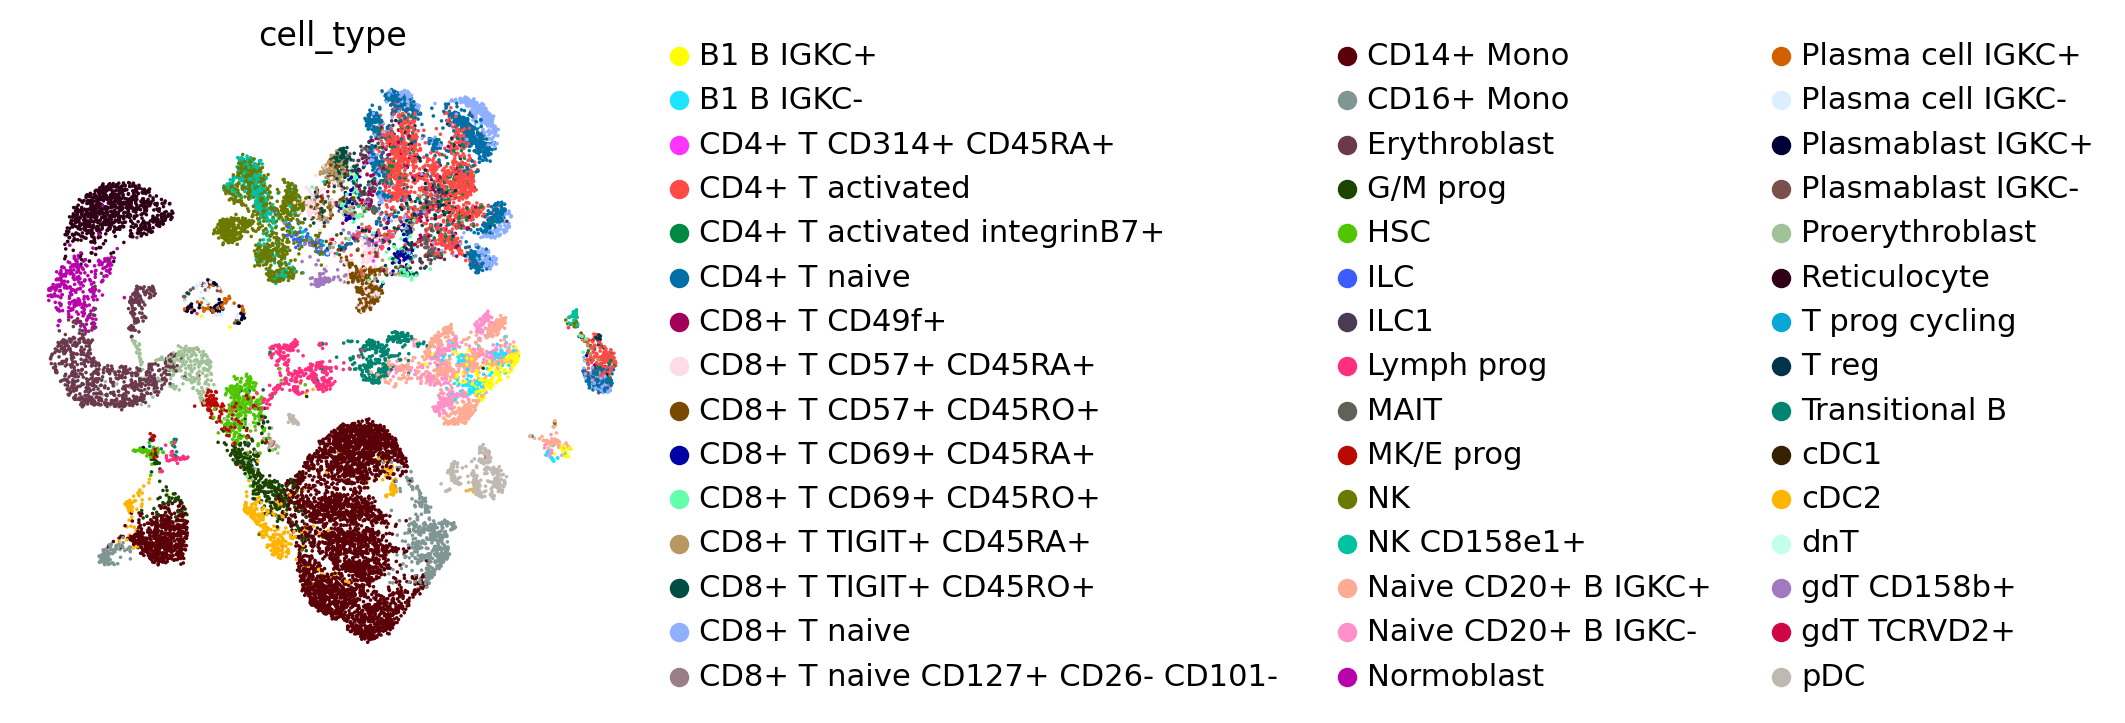

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


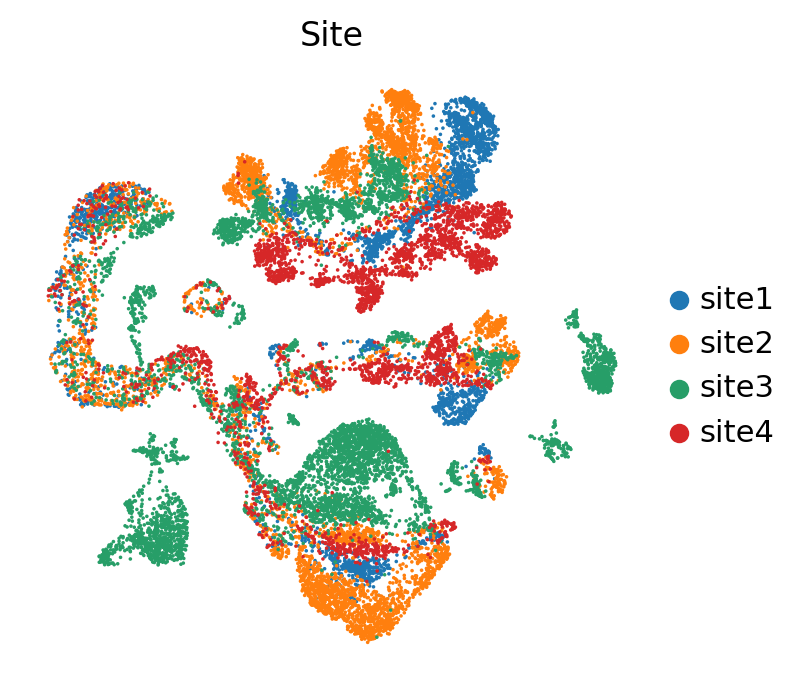

In [11]:
sc.pl.umap(adata_original, color=["cell_type"])
sc.pl.umap(adata_original, color=["Site"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


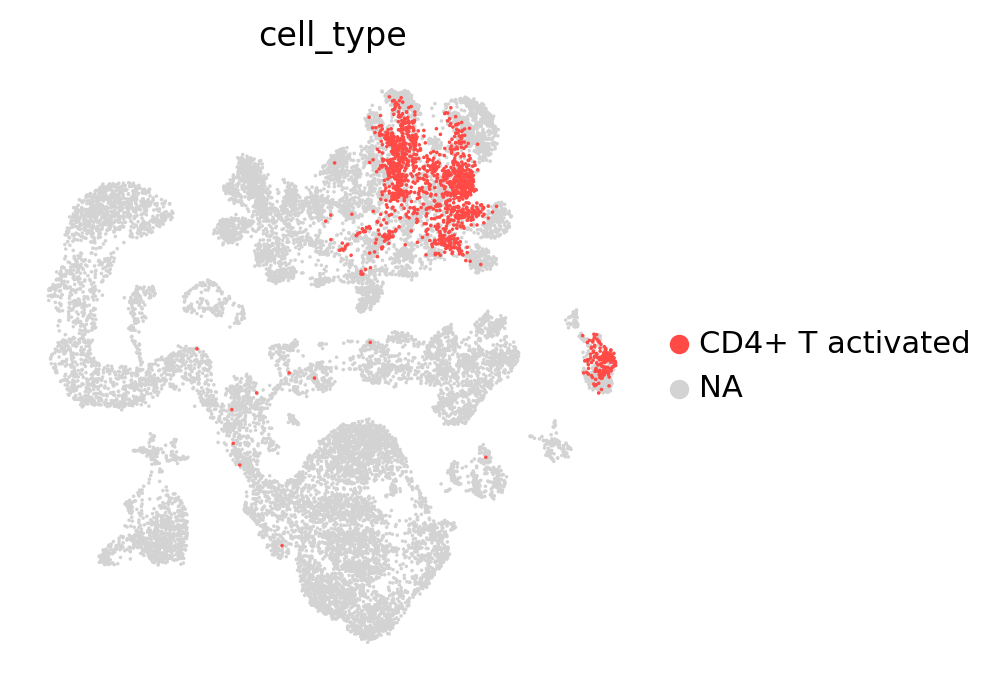

In [12]:
sc.pl.umap(adata_original, color="cell_type", groups="CD4+ T activated")

# COMBINATION OF CONDITIONS 

In [13]:
generative_model.guidance_weights

{'cell_type': 1, 'Site': 1}

In [14]:
dataset.id2cov["cell_type"]

{'B1 B IGKC+': 0,
 'B1 B IGKC-': 1,
 'CD14+ Mono': 2,
 'CD16+ Mono': 3,
 'CD4+ T CD314+ CD45RA+': 4,
 'CD4+ T activated': 5,
 'CD4+ T activated integrinB7+': 6,
 'CD4+ T naive': 7,
 'CD8+ T CD49f+': 8,
 'CD8+ T CD57+ CD45RA+': 9,
 'CD8+ T CD57+ CD45RO+': 10,
 'CD8+ T CD69+ CD45RA+': 11,
 'CD8+ T CD69+ CD45RO+': 12,
 'CD8+ T TIGIT+ CD45RA+': 13,
 'CD8+ T TIGIT+ CD45RO+': 14,
 'CD8+ T naive': 15,
 'CD8+ T naive CD127+ CD26- CD101-': 16,
 'Erythroblast': 17,
 'G/M prog': 18,
 'HSC': 19,
 'ILC': 20,
 'ILC1': 21,
 'Lymph prog': 22,
 'MAIT': 23,
 'MK/E prog': 24,
 'NK': 25,
 'NK CD158e1+': 26,
 'Naive CD20+ B IGKC+': 27,
 'Naive CD20+ B IGKC-': 28,
 'Normoblast': 29,
 'Plasma cell IGKC+': 30,
 'Plasma cell IGKC-': 31,
 'Plasmablast IGKC+': 32,
 'Plasmablast IGKC-': 33,
 'Proerythroblast': 34,
 'Reticulocyte': 35,
 'T prog cycling': 36,
 'T reg': 37,
 'Transitional B': 38,
 'cDC1': 39,
 'cDC2': 40,
 'dnT': 41,
 'gdT CD158b+': 42,
 'gdT TCRVD2+': 43,
 'pDC': 44}

In [15]:
dataset.id2cov["Site"]

{'site1': 0, 'site2': 1, 'site3': 2, 'site4': 3}

In [16]:
# Pick condition 
covariates_cell_types = 'CD4+ T activated'
covariates_site = 'site1'

condition_id_ct = dataset.id2cov["cell_type"][covariates_cell_types]
condition_id_site = dataset.id2cov["Site"][covariates_site]

adata_cond = adata_original[np.logical_and(adata_original.obs.cell_type==covariates_cell_types, 
                                           adata_original.obs.Site==covariates_site)]
n_to_generate = adata_cond.shape[0]

classes = {"cell_type": condition_id_ct*torch.ones(n_to_generate).long(), 
           "Site": condition_id_site*torch.ones(n_to_generate).long()}

classes_str = {"cell_type": [covariates_cell_types for n in range(n_to_generate)], 
           "Site": [covariates_site for n in range(n_to_generate)]}

log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda()

In [17]:
generative_model.denoising_model.conditioning_probability

0.8

In [18]:
X_generated = generative_model.sample(batch_size=n_to_generate,
                                        n_sample_steps=100, 
                                        theta_covariate="cell_type", 
                                        size_factor_covariate="cell_type",
                                        conditioning_covariates=["cell_type", "Site"],
                                        covariate_indices=classes, 
                                        log_size_factor=log_size_factors)

X_generated = X_generated.to("cpu")

adata_generated = sc.AnnData(X=X_generated.numpy())

In [19]:
adata_merged = join_real_generated(adata_original, adata_generated, True, classes_str, ["cell_type", "Site"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [20]:
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:346: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/numba/core/types/functions.py", line 486, in __getnewargs__
    raise ReferenceError("underlying object has vanished")

  init_rp_tree(data, dist, current_graph, leaf_array)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:348: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style'

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python

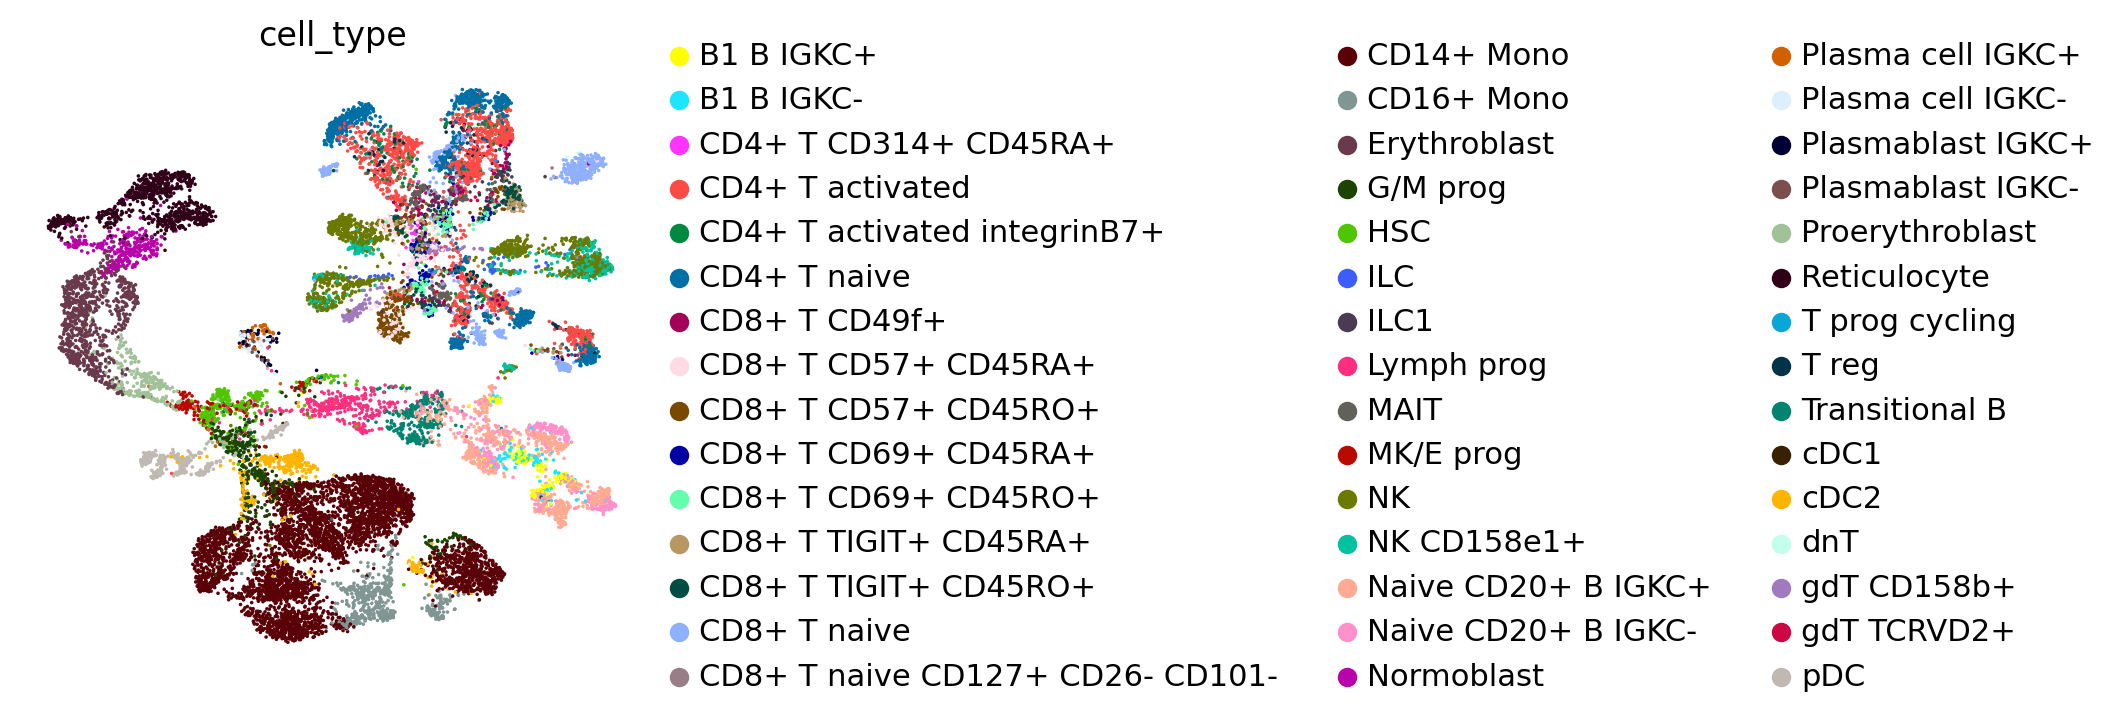

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python

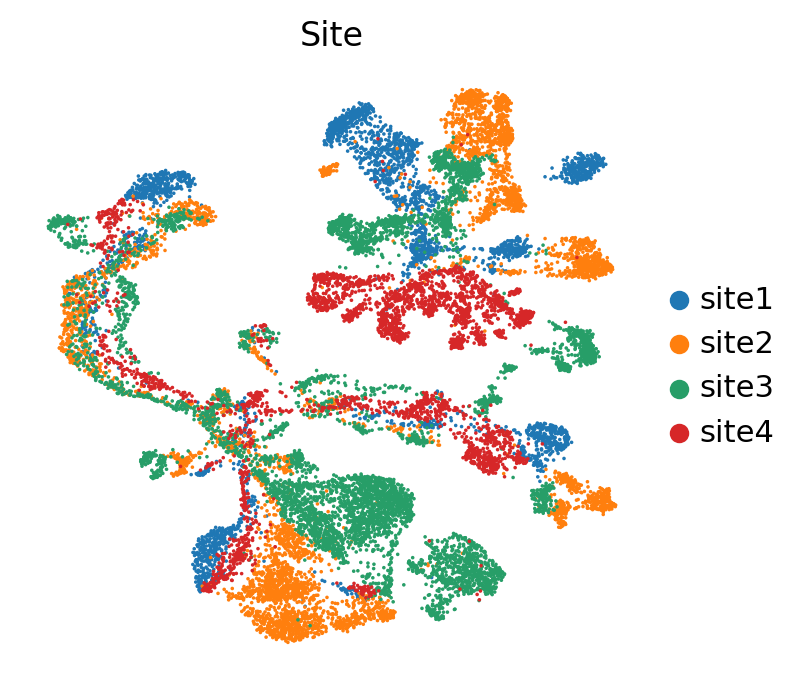

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


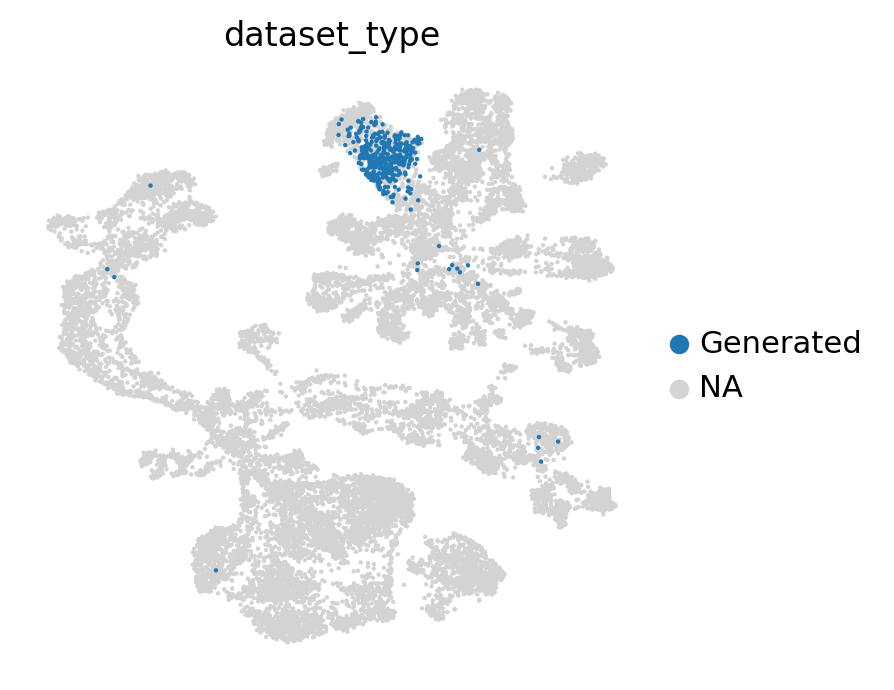

In [21]:
sc.pl.umap(adata_merged[adata_merged.obs.dataset_type=="Real"], color="cell_type")
sc.pl.umap(adata_merged[adata_merged.obs.dataset_type=="Real"], color="Site")
sc.pl.umap(adata_merged, color="dataset_type", groups="Generated", s=10)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


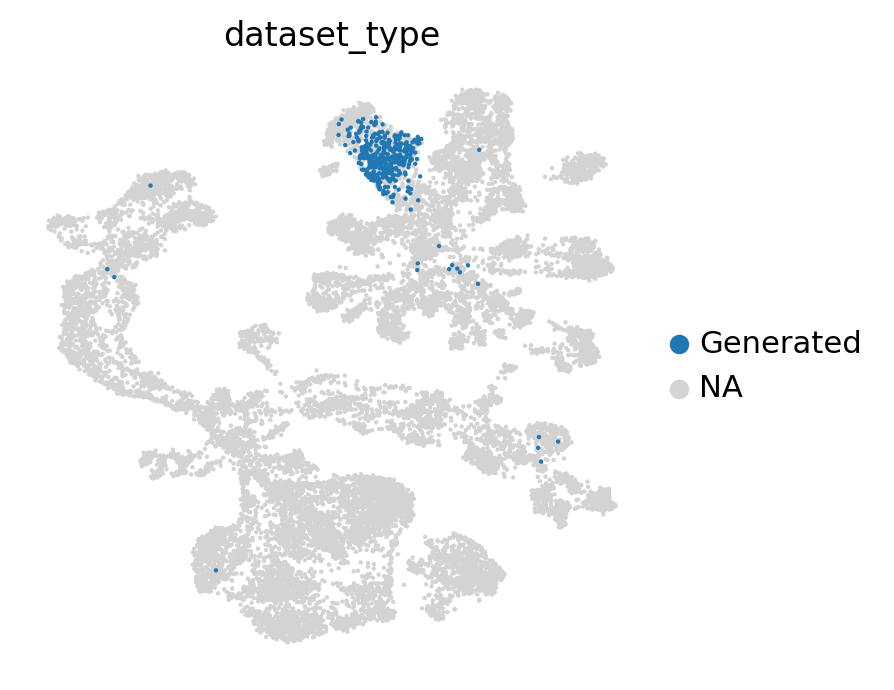

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [22]:
# sc.pl.pca(adata_merged, color="dataset_type",  annotate_var_explained=True)
sc.pl.umap(adata_merged, color="dataset_type", groups="Generated",s=10)
sc.pl.umap(adata_merged, color="cell_type", groups="CD4+ T activated",s=10)
sc.pl.umap(adata_merged, color="Site", groups="site1",s=10, palette="jet")

## SINGLE CONDITION - cell type

In [23]:
# Pick condition 
covariates_cell_types = 'CD4+ T activated'

condition_id_cell_types = dataset.id2cov["cell_type"][covariates_cell_types]

adata_cond = adata_original[adata_original.obs.cell_type==covariates_cell_types]

n_to_generate = adata_cond.shape[0]

classes = {"cell_type": condition_id_cell_types*torch.ones(n_to_generate).long(), 
           "Site": condition_id_site*torch.ones(n_to_generate).long()}

classes_str = {"cell_type": [covariates_cell_types for n in range(n_to_generate)], 
           "Site": [covariates_site for n in range(n_to_generate)]}

log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda()

In [24]:
X_generated_cell_type = generative_model.sample(batch_size=n_to_generate,
                                        n_sample_steps=100, 
                                        theta_covariate="cell_type", 
                                        size_factor_covariate="cell_type",
                                        conditioning_covariates=["cell_type"],
                                        covariate_indices=classes, 
                                        log_size_factor=log_size_factors)

X_generated_cell_type = X_generated_cell_type.to("cpu")

adata_generated_cell_type = sc.AnnData(X=X_generated_cell_type.cpu().numpy())

In [25]:
adata_merged_cell_type = join_real_generated(adata_original, adata_generated_cell_type, True, classes_str, ["cell_type", "Site"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [26]:
sc.pp.neighbors(adata_merged_cell_type)
sc.tl.umap(adata_merged_cell_type)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python

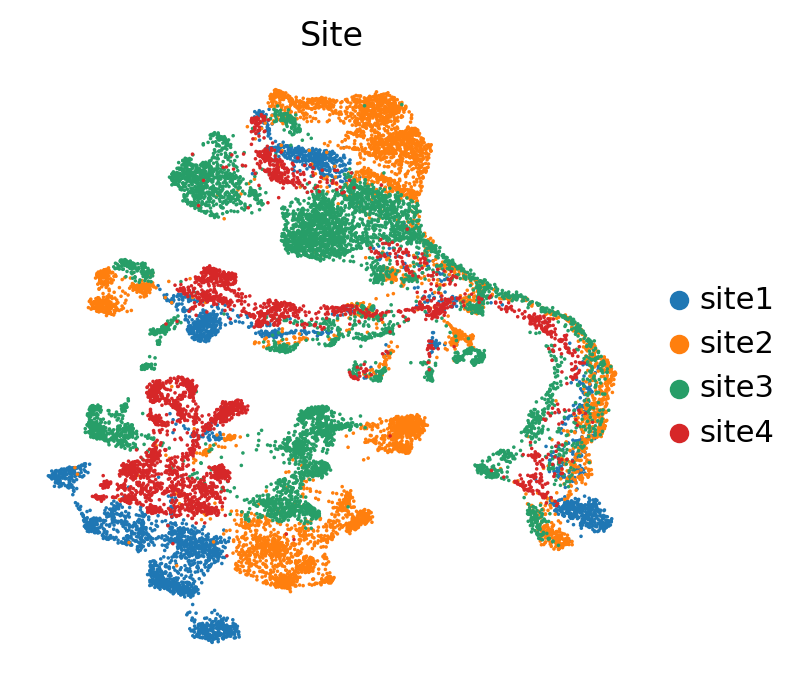

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


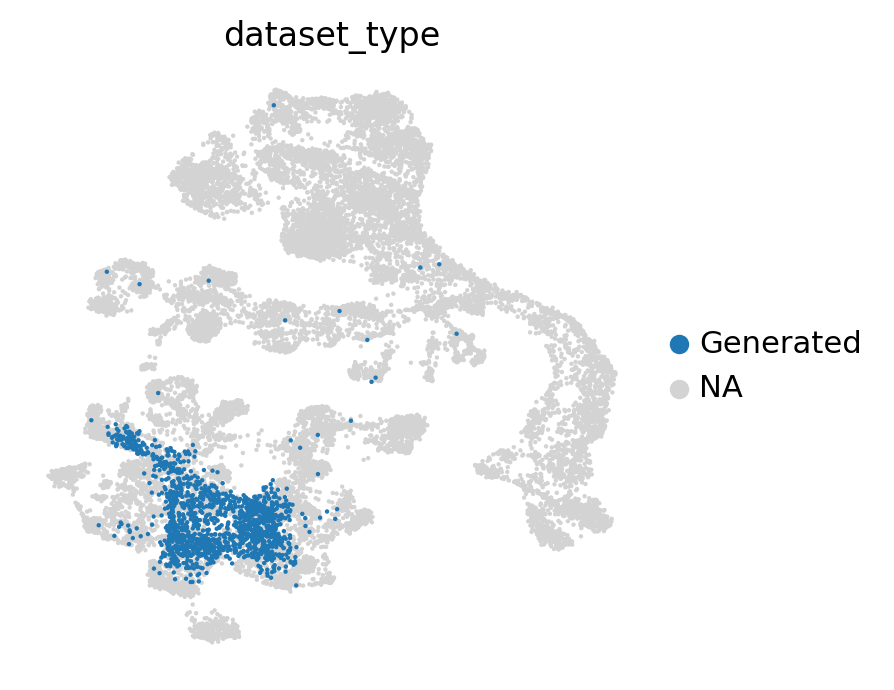

In [27]:
sc.pl.umap(adata_merged_cell_type[adata_merged_cell_type.obs.dataset_type=="Real"], color="cell_type")
sc.pl.umap(adata_merged_cell_type[adata_merged_cell_type.obs.dataset_type=="Real"], color="Site")
sc.pl.umap(adata_merged_cell_type, color="dataset_type", groups="Generated", s=10)

## SINGLE CONDITION - batch

In [28]:
# Pick condition 
covariates_site = 'site1'

condition_id_site = dataset.id2cov["Site"][covariates_site]

adata_cond = adata_original[adata_original.obs.Site==covariates_site]
n_to_generate = adata_cond.shape[0]

classes = {"cell_type": condition_id_cell_types*torch.ones(n_to_generate).long(), 
           "Site": condition_id_site*torch.ones(n_to_generate).long()}

classes_str = {"cell_type": list(adata_cond.obs.cell_type), 
           "Site": [covariates_site for n in range(n_to_generate)]}

log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda()

In [29]:
X_generated_site = generative_model.sample(batch_size=n_to_generate,
                                            n_sample_steps=2, 
                                            theta_covariate="cell_type", 
                                            size_factor_covariate="cell_type",
                                            conditioning_covariates=["Site"],
                                            covariate_indices=classes, 
                                            log_size_factor=log_size_factors)

X_generated_site = X_generated_site.to("cpu")

adata_generated_site = sc.AnnData(X=X_generated_site.cpu().numpy())

In [30]:
adata_merged_site = join_real_generated(adata_original, adata_generated_site, True, classes_str, ["cell_type", "Site"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [31]:
sc.pp.neighbors(adata_merged_site)
sc.tl.umap(adata_merged_site)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python

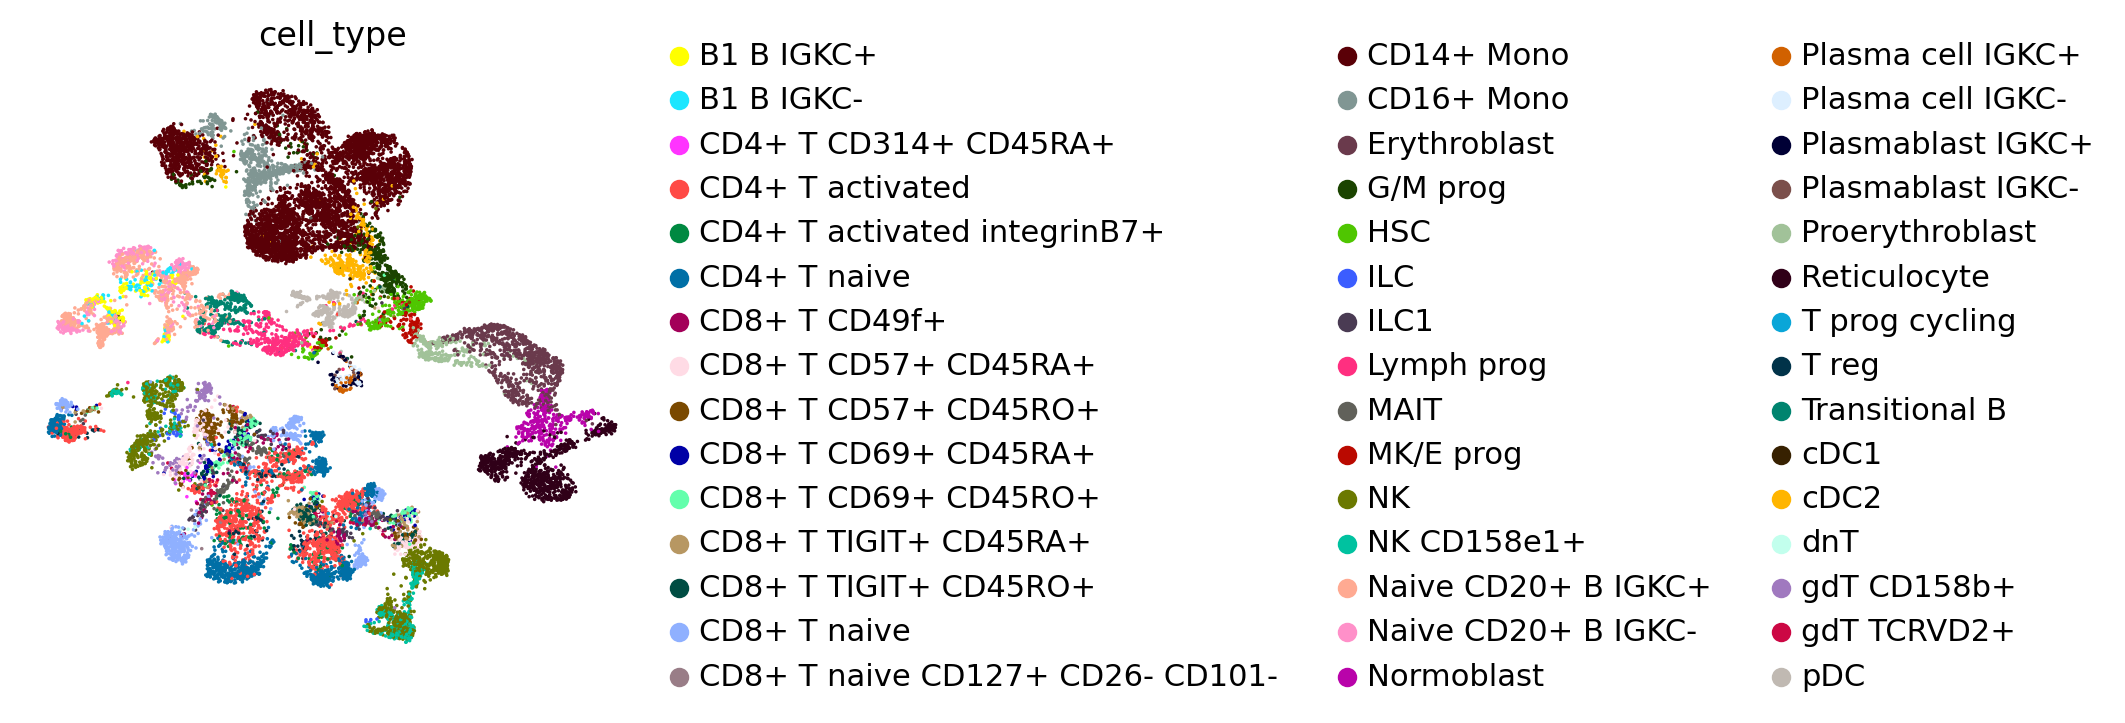

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python

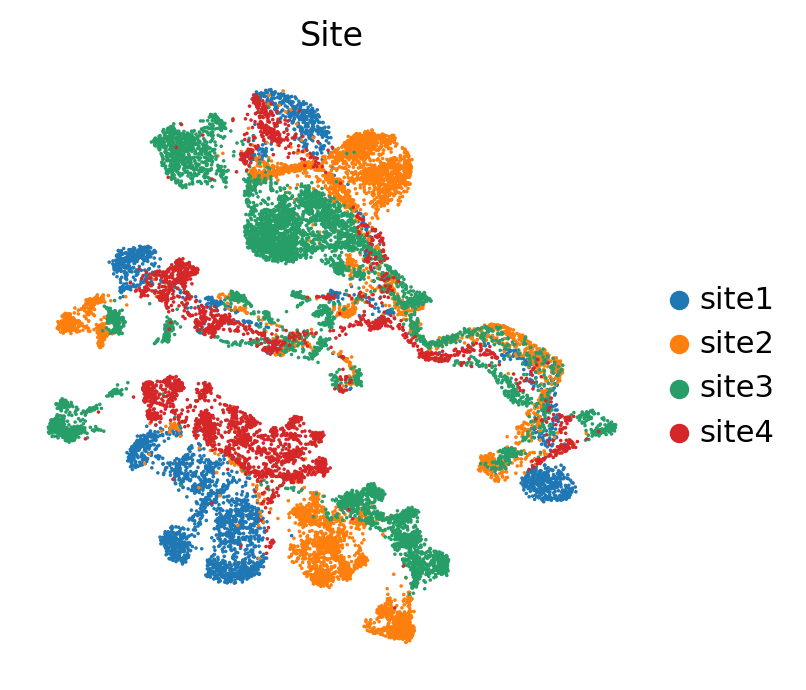

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


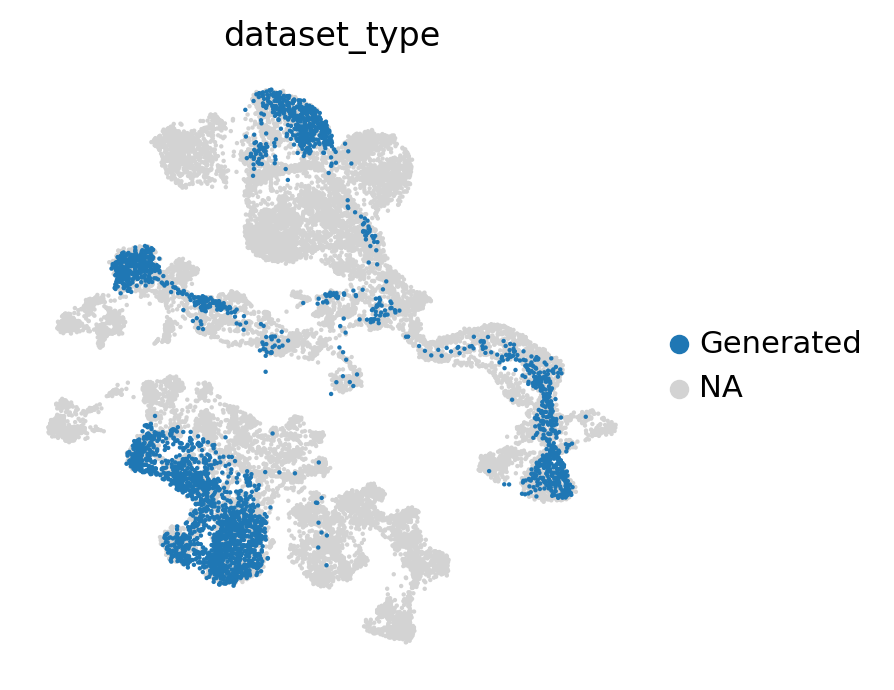

In [32]:
sc.pl.umap(adata_merged_site[adata_merged_site.obs.dataset_type=="Real"], color="cell_type")
sc.pl.umap(adata_merged_site[adata_merged_site.obs.dataset_type=="Real"], color="Site")
sc.pl.umap(adata_merged_site, color="dataset_type", groups="Generated", s=10)

## UNCONDITIONAL

In [33]:
num_indices = 18000
index_range = len(X)

# Generate random dummy indices without replacement
indices = random.sample(range(index_range), num_indices)
adata_indices = adata_original[indices]

classes_cell_type_str =  list(adata_indices.obs.cell_type)
classes_cell_type = torch.tensor([dataset.id2cov["cell_type"][c] for  c in classes_cell_type_str]).cuda()

classes_site_str =  list(adata_indices.obs.Site)
classes_site = torch.tensor([dataset.id2cov["Site"][c] for  c in classes_site_str]).cuda()

classes_str = {"cell_type": classes_cell_type_str, 
           "Site": classes_site_str}

log_size_factors = torch.log(torch.tensor(adata_indices.layers["X_counts"].sum(1))).cuda()

In [34]:
X_generated_uncond = generative_model.sample(batch_size=num_indices,
                                            n_sample_steps=2, 
                                            theta_covariate="cell_type", 
                                            size_factor_covariate="cell_type",
                                            conditioning_covariates=["cell_type"],
                                            covariate_indices=None, 
                                            log_size_factor=log_size_factors, 
                                            unconditional=True)

X_generated_uncond = X_generated_uncond.to("cpu")
adata_generated_uncond = sc.AnnData(X=X_generated_uncond.cpu().numpy())

OutOfMemoryError: CUDA out of memory. Tried to allocate 968.00 MiB. GPU 0 has a total capacty of 19.50 GiB of which 647.19 MiB is free. Process 2131457 has 12.05 GiB memory in use. Process 2131704 has 4.34 GiB memory in use. Process 3252160 has 3.18 GiB memory in use. Process 3299878 has 176.00 MiB memory in use. Including non-PyTorch memory, this process has 2.24 GiB memory in use. Of the allocated memory 2.02 GiB is allocated by PyTorch, and 11.23 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
adata_merged_uncond = join_real_generated(adata_original, adata_generated_uncond, True, classes_str, ["cell_type", "Site"])

In [ ]:
sc.pp.neighbors(adata_merged_uncond)
sc.tl.umap(adata_merged_uncond)

In [ ]:
sc.pl.umap(adata_merged_uncond[adata_merged_uncond.obs.dataset_type=="Real"], color="cell_type")
sc.pl.umap(adata_merged_uncond[adata_merged_uncond.obs.dataset_type=="Real"], color="Site")
sc.pl.umap(adata_merged_uncond, color="dataset_type", groups="Generated", s=10)